<a href="https://colab.research.google.com/github/VintageGold/Outages_Prediction/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
 
from google.colab import drive

drive.mount('/content/drive')
%cd drive/My\ Drive/
os.getcwd()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


'/content/drive/My Drive'

## Functions

In [ ]:
import datetime as dt
def convert_dt(df,col_name=None,year=True,month=True):
    df[col_name] = pd.to_datetime(df[col_name])
    
    df['plot_date'] = pd.to_datetime(df[col_name].dt.strftime('%Y-%m-%d'))
    df['agg_date'] = df[col_name].dt.strftime('%m%d%Y')

    if year:
        df['year'] = df['agg_date'].str[-4:]
    if month:
        df['month'] = df['agg_date'].str[0:2]
        df = df.astype({'month': 'int64'})
    
    df = df.drop(columns='agg_date')
    return df

In [ ]:
def get_month_season(df):
    df_month = pd.read_csv('UMBC_Energy/Universal_Data/months.csv')
    df = df.merge(df_month,on='month',how='left')
    df = df.astype({'month': 'object'})
    return df

# NOAA Weather Data

In [ ]:
df_NOAA_trim = pd.read_csv('UMBC_Energy/Raw/df_NOAA_Station_Trim_mkt_region.csv')
df_NOAA_trim.head()

,Unnamed: 0,station,Code,Key,NS,WEC,Combined,station_dt_key,date,PRCP,SNOW,SNWD,AWND,TMAX,TMIN,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,state,location_type,location,State,plot_date,year,month,month_name,season,TDIFF,Code_station,mkt_region,region
0,0,GHCND:USC00182325,DC,GHCND:USC00182325DC,North,West,NorthWest,GHCND:USC00182325_2015-01-01,2015-01-01,0.00,0.0,0.0,NaN,36.0,21.0,45.7,1948-08-01,2020-03-31,38.9385,"DALECARLIA RESERVOIR, DC US",1.0,GHCND:USC00182325,METERS,-77.1134,District of Columbia,GHCND,USC00182325,District of Columbia,2015-01-01,2015,1,Jan,Winter,15.0,GHCND:USC00182325DC,MIDATL,Mid Atlantic - Dominion
1,1,GHCND:USC00182325,DC,GHCND:USC00182325DC,North,West,NorthWest,GHCND:USC00182325_2015-01-02,2015-01-02,0.00,0.0,0.0,NaN,43.0,21.0,45.7,1948-08-01,2020-03-31,38.9385,"DALECARLIA RESERVOIR, DC US",1.0,GHCND:USC00182325,METERS,-77.1134,District of Columbia,GHCND,USC00182325,District of Columbia,2015-01-02,2015,1,Jan,Winter,22.0,GHCND:USC00182325DC,MIDATL,Mid Atlantic - Dominion
2,2,GHCND:USC00182325,DC,GHCND:USC00182325DC,North,West,NorthWest,GHCND:USC00182325_2015-01-03,2015-01-03,0.00,0.0,0.0,NaN,46.0,27.0,45.7,1948-08-01,2020-03-31,38.9385,"DALECARLIA RESERVOIR, DC US",1.0,GHCND:USC00182325,METERS,-77.1134,District of Columbia,GHCND,USC00182325,District of Columbia,2015-01-03,2015,1,Jan,Winter,19.0,GHCND:USC00182325DC,MIDATL,Mid Atlantic - Dominion
3,3,GHCND:USC00182325,DC,GHCND:USC00182325DC,North,West,NorthWest,GHCND:USC00182325_2015-01-04,2015-01-04,0.69,0.0,0.0,NaN,46.0,27.0,45.7,1948-08-01,2020-03-31,38.9385,"DALECARLIA RESERVOIR, DC US",1.0,GHCND:USC00182325,METERS,-77.1134,District of Columbia,GHCND,USC00182325,District of Columbia,2015-01-04,2015,1,Jan,Winter,19.0,GHCND:USC00182325DC,MIDATL,Mid Atlantic - Dominion
4,4,GHCND:USC00182325,DC,GHCND:USC00182325DC,North,West,NorthWest,GHCND:USC00182325_2015-01-05,2015-01-05,0.00,0.0,0.0,NaN,44.0,35.0,45.7,1948-08-01,2020-03-31,38.9385,"DALECARLIA RESERVOIR, DC US",1.0,GHCND:USC00182325,METERS,-77.1134,District of Columbia,GHCND,USC00182325,District of Columbia,2015-01-05,2015,1,Jan,Winter,9.0,GHCND:USC00182325DC,MIDATL,Mid Atlantic - Dominion


## High Level view of NOAA weather data across the 4 years collected
  

*   Below we can see a strong seasonal pattern in TMAX and TMIN.
*   PRCP looks to be pretty constant throughout seasons.  
*   SNOW as expected is infrequent and only appear during the winter season and sometime early spring.  As Marylanders we have experienced that.
*   As we an see AWND is not accounted for enough so this feature is dropped.



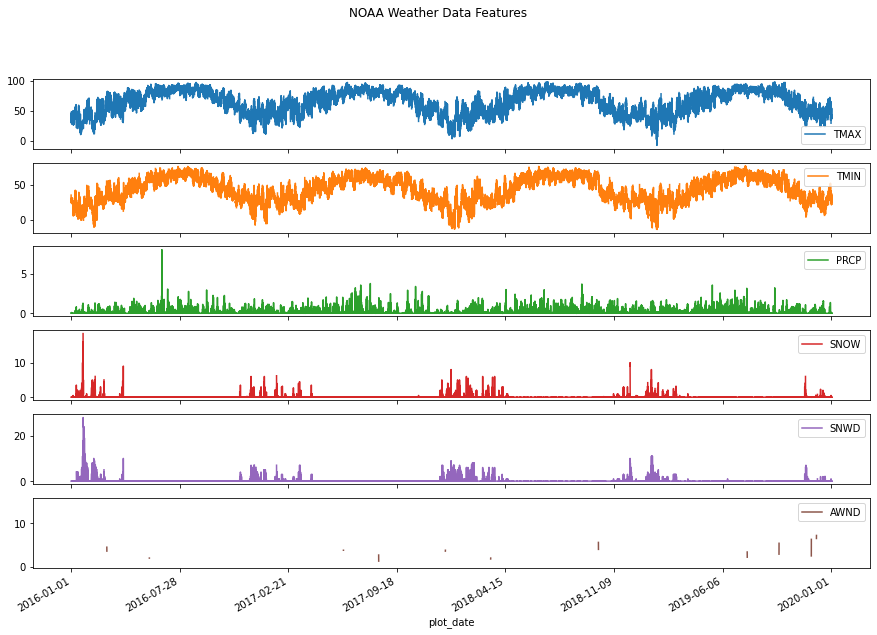

In [ ]:


plot_cols = ['plot_date','Code','season','year','month_name','mkt_region','region','PRCP','SNOW','SNWD','AWND','TMAX','TMIN']

df_plot = df_NOAA_trim[['TMAX','TMIN','PRCP','SNOW','SNWD','AWND','region','plot_date','season']].set_index('plot_date').sort_index(ascending=True).query('region == "Western"')


df_plot = df_plot['2016-01-01':'2020-01-02']

_ = df_plot.plot(subplots=True,title = 'NOAA Weather Data Features',figsize=(15,10))




## Monthly View of NOAA Weather Data

We have more detailed view at TMAX throughout the seasons clearly here.  The TMAX start off low rise during the spring spring even more in the summer and then begin to tail off in autumn/fall

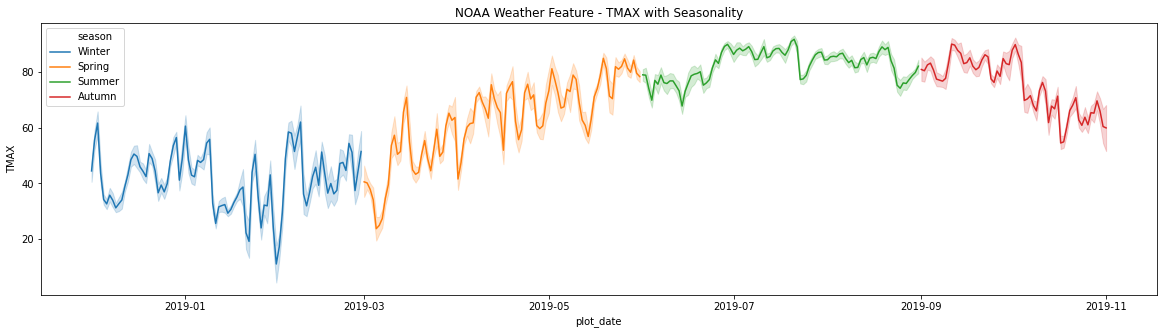

In [ ]:
plt.figure(figsize=(20,5))
df_plot = df_plot['2018-12-01':'2019-11-01']

df_plot = df_plot.reset_index()

date_time = pd.to_datetime(df_plot.pop('plot_date'),format='%Y-%m-%d')

_ = sns.lineplot(data=df_plot,x=date_time, y='TMAX',hue='season')
_ = plt.title('NOAA Weather Feature - TMAX with Seasonality')

We can see the same trend for TMIN as describe in TMAX

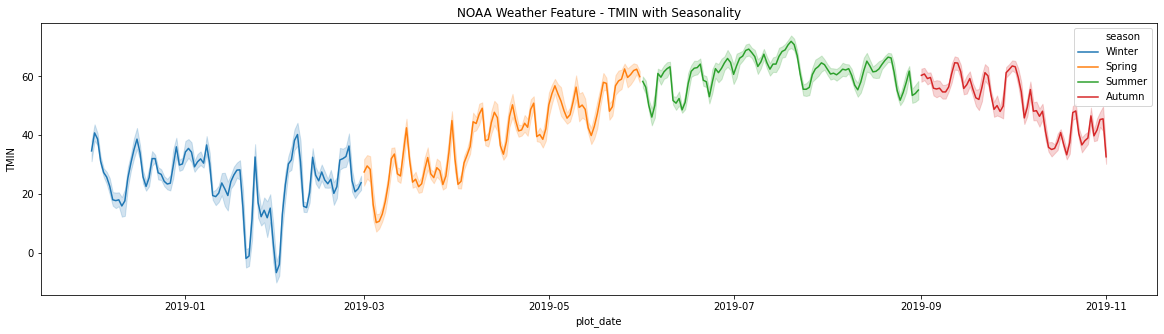

In [ ]:
plt.figure(figsize=(20,5))
_ = sns.lineplot(data=df_plot,x=date_time, y='TMIN',hue='season')
_ = plt.title('NOAA Weather Feature - TMIN with Seasonality')

PRCP tends to be consistent throughout the seasons

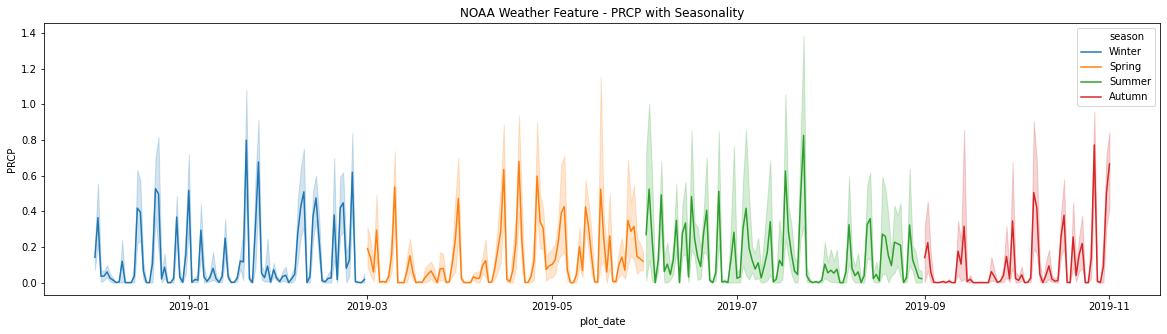

In [ ]:
plt.figure(figsize=(20,5))
_ = sns.lineplot(data=df_plot,x=date_time, y='PRCP',hue='season')
_ = plt.title('NOAA Weather Feature - PRCP with Seasonality')

SNOW as expected is active during the winter and early spring, and is flat during the summer and autumn

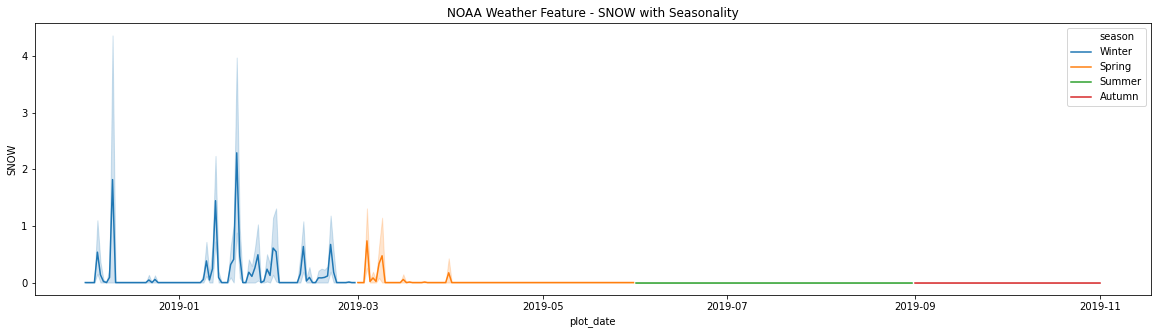

In [ ]:
plt.figure(figsize=(20,5))
_ = sns.lineplot(data=df_plot,x=date_time, y='SNOW',hue='season')
_ = plt.title('NOAA Weather Feature - SNOW with Seasonality')

SNWD as expected is active during the winter and early spring, and is flat during the summer and autumn

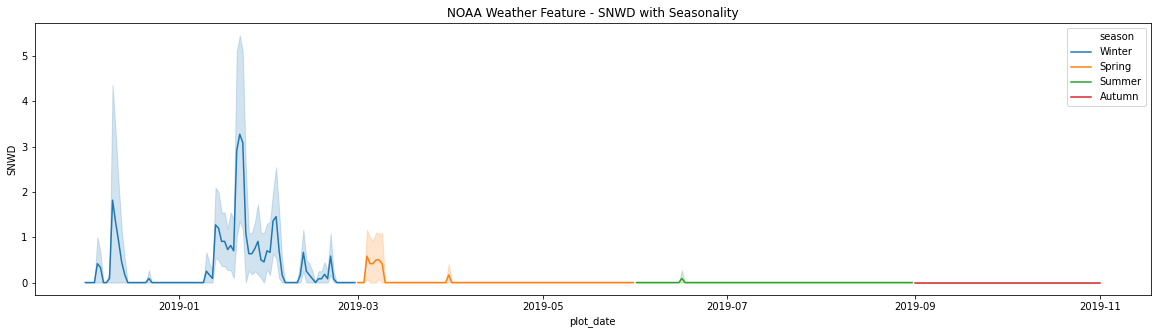

In [ ]:
plt.figure(figsize=(20,5))
_ = sns.lineplot(data=df_plot,x=date_time, y='SNWD',hue='season')
_ = plt.title('NOAA Weather Feature - SNWD with Seasonality')

# Outage 

In [ ]:
df_outage = pd.read_csv('UMBC_Energy/forecast_matched_execution.csv',index_col=[0])

df_outage = df_outage.reset_index()

df_outage = convert_dt(df_outage,col_name='forecast_execution_date_ept')

df_outage = get_month_season(df_outage)

df_outage = df_outage[df_outage.region == 'Mid Atlantic - Dominion'].set_index('forecast_execution_date_ept')

df_outage = df_outage['2016-01-01':'2020-01-02'].drop(columns = 'index')

all_year_range = '2016 - 2020'

df_outage

,forecast_date,region,total_outages_mw,planned_outages_mw,maintenance_outages_mw,forced_outages_mw,execution_date,forecast_just_date,date_match,plot_date,year,month,month_name,season
forecast_execution_date_ept,,,,,,,,,,,,,,
2016-12-31,2016-12-31,Mid Atlantic - Dominion,5082,1025,2864,1193,12312016,12312016,yes,2016-12-31,2016,12,Dec,Winter
2016-12-30,2016-12-30,Mid Atlantic - Dominion,4425,1405,2074,946,12302016,12302016,yes,2016-12-30,2016,12,Dec,Winter
2016-12-29,2016-12-29,Mid Atlantic - Dominion,5233,1405,2582,1246,12292016,12292016,yes,2016-12-29,2016,12,Dec,Winter
2016-12-28,2016-12-28,Mid Atlantic - Dominion,4801,1405,2055,1341,12282016,12282016,yes,2016-12-28,2016,12,Dec,Winter
2016-12-27,2016-12-27,Mid Atlantic - Dominion,4332,1405,1902,1025,12272016,12272016,yes,2016-12-27,2016,12,Dec,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-03,2019-01-03,Mid Atlantic - Dominion,4751,697,2397,1657,1032019,1032019,yes,2019-01-03,2019,1,Jan,Winter
2019-01-02,2019-01-02,Mid Atlantic - Dominion,4059,697,1582,1780,1022019,1022019,yes,2019-01-02,2019,1,Jan,Winter
2019-01-01,2019-01-01,Mid Atlantic - Dominion,2769,697,429,1643,1012019,1012019,yes,2019-01-01,2019,1,Jan,Winter


### From this plot we can tell that Forced outages are the lowest form of outage.

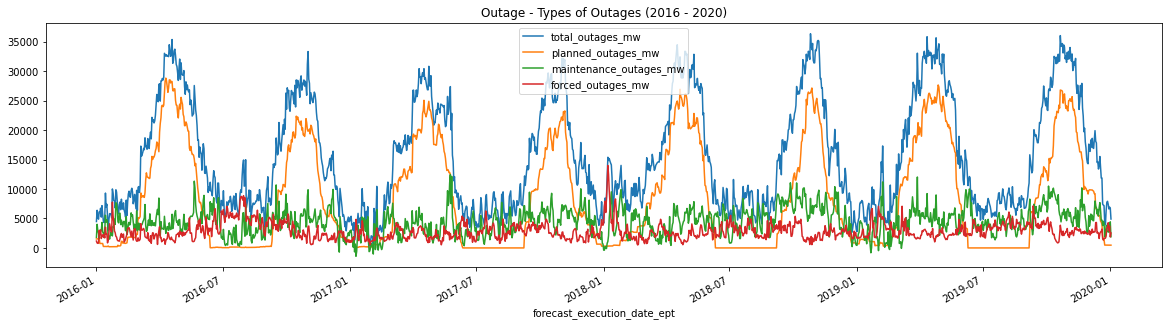

In [ ]:
df_outage_2019 = df_outage['2018-12-01':'2019-11-01']
_ = df_outage[['total_outages_mw','planned_outages_mw','maintenance_outages_mw','forced_outages_mw']].plot(title = f'Outage - Types of Outages ({all_year_range})',figsize=(20,5))

## From the plot below we can see an cyclical trend with a massive spike in January 2018

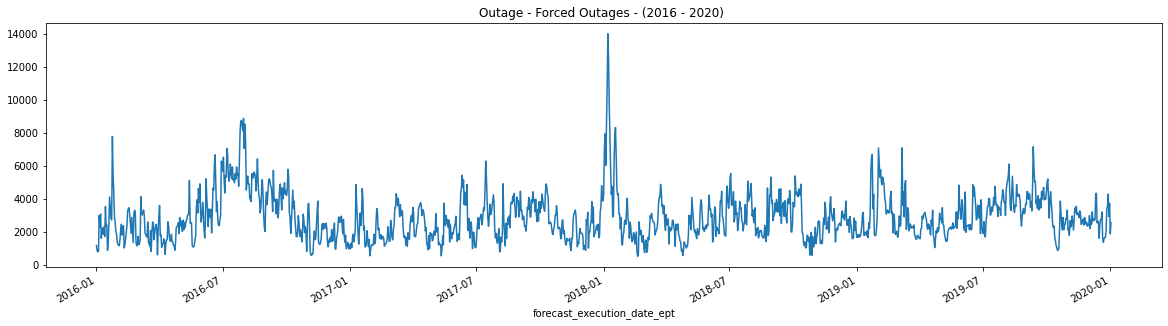

In [ ]:
_ = df_outage['forced_outages_mw'].plot(title = f'Outage - Forced Outages - ({all_year_range}) ',figsize=(20,5))

## If we select 2019 we will more outages happening in colder months than warmer months which is interesting and unexpected

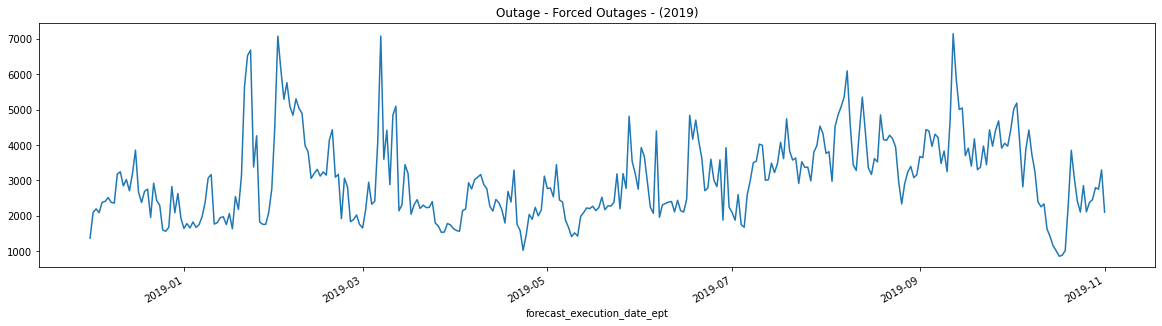

In [ ]:
year_range = '2019'
_ = df_outage_2019['forced_outages_mw'].plot(title = f'Outage - Forced Outages - ({year_range})',figsize=(20,5))

## When we color code the chart with seasons it's easier to decipher that there tends to be an increase when seasons change.  Such as April to May or 2019 - 04 to 2019 - 05.  In addtion 2019 - 08 to 2019 - 09.

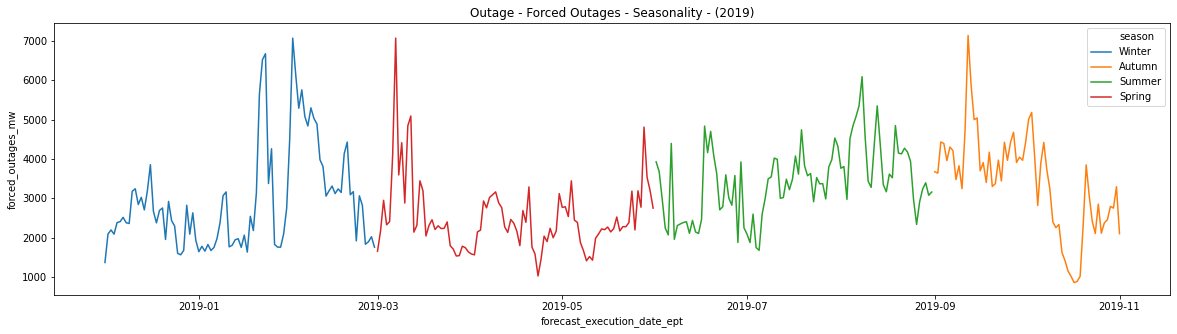

In [ ]:
plt.figure(figsize=(20,5))

df_outage_2019 = df_outage_2019.reset_index()
_ = sns.lineplot(data=df_outage_2019,x='forecast_execution_date_ept', y='forced_outages_mw',hue='season')


_ = plt.title(f'Outage - Forced Outages - Seasonality - ({year_range})')



# Usage

In [ ]:
df_usage = pd.read_csv('UMBC_Energy/Energy_usage/Usage_months_seasons_ept.csv',index_col=[0])

In [ ]:
df_usage

,datetime_beginning_utc,nerc_region,mkt_region,zone,load_area,mw,is_verified,plot_date,year,month,month_name,season
datetime_beginning_ept,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01 05:00:00,RFC,MIDATL,DPL,DPL,2437.433,True,2015-01-01 00:00:00,2015,1,Jan,Winter
2015-01-01 00:00:00,2015-01-01 05:00:00,RFC,MIDATL,PEP,PEP,3561.818,True,2015-01-01 00:00:00,2015,1,Jan,Winter
2015-01-01 00:00:00,2015-01-01 05:00:00,RFC,WEST,AEP,AEP,16176.032,True,2015-01-01 00:00:00,2015,1,Jan,Winter
2015-01-01 00:00:00,2015-01-01 05:00:00,RFC,MIDATL,AE,AE,1180.082,True,2015-01-01 00:00:00,2015,1,Jan,Winter
2015-01-01 00:00:00,2015-01-01 05:00:00,RFC,MIDATL,BC,BC,3940.727,True,2015-01-01 00:00:00,2015,1,Jan,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01 23:00:00,2020-07-02 03:00:00,RFC,MIDATL,RECO,RECO,182.180,False,2020-07-01 00:00:00,2020,7,Jul,Summer
2020-07-01 23:00:00,2020-07-02 03:00:00,RFC,MIDATL,PEP,SMECO,379.719,False,2020-07-01 00:00:00,2020,7,Jul,Summer
2020-07-01 23:00:00,2020-07-02 03:00:00,RFC,MIDATL,PL,UGI,116.904,False,2020-07-01 00:00:00,2020,7,Jul,Summer


In [ ]:
df_outage = df_usage[df_usage.mkt_region == 'MIDATL']

df_usage = df_usage['2016-01-01':'2020-01-02']

### Usage data over the years looks consistent and looks hints to a predictable trend

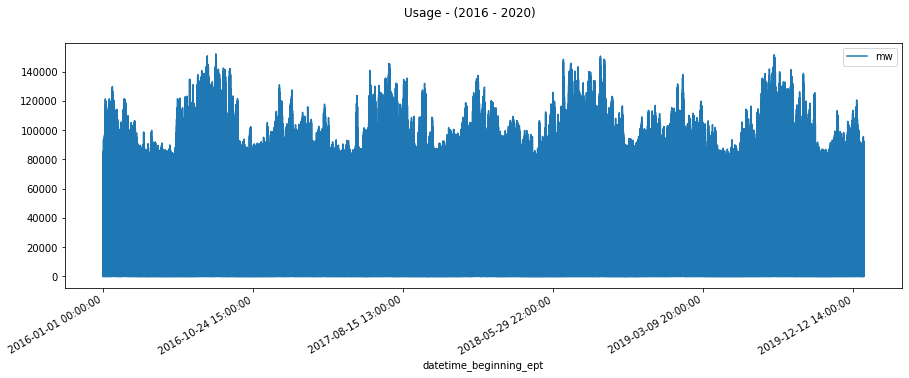

In [ ]:
_ = df_usage.drop(columns=['year','month']).plot(subplots=True,title = 'Usage - (2016 - 2020)',figsize=(15,5))

### Look at one year and see the trend.  I appears that the usage is high in the winter, falls off during spring, then hits the maximum peaks in the summer then tails off in the fall.

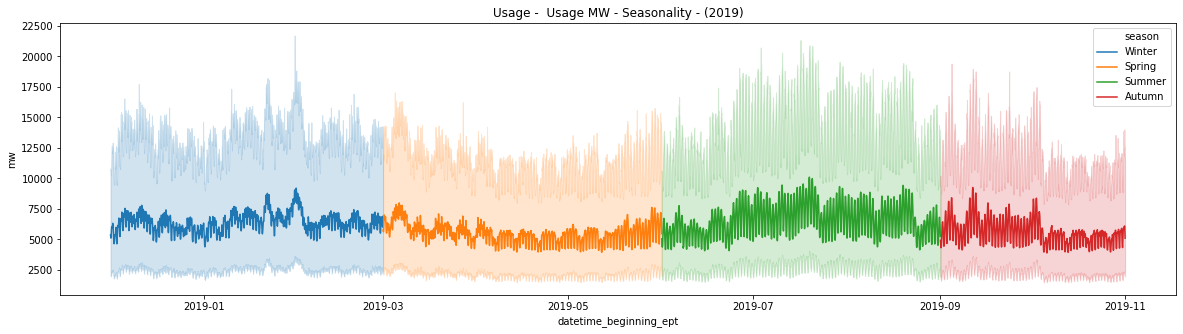

In [ ]:
plt.figure(figsize=(20,5))

df_usage_2019 = df_usage['2018-12-01':'2019-11-01']

df_usage_2019 = df_usage_2019.reset_index()

date_time = pd.to_datetime(df_usage_2019.pop('datetime_beginning_ept'),format='%Y-%m-%d %H:%M:%S')


_ = sns.lineplot(data=df_usage_2019,x=date_time, y='mw',hue='season')


_ = plt.title(f'Usage -  Usage MW - Seasonality - ({year_range})')



# Outage - Usage - Weather

In [ ]:
df = pd.read_csv('UMBC_Energy/Model_ready/Outage_Usage_Weather_ept.csv',index_col='plot_date')
df = df.reset_index()
df = df.astype({'year': 'object','month':'object'})
df = df.drop(columns=['AWND','total_outages_mw','planned_outages_mw','maintenance_outages_mw','plot_date','TDIFF'])
df = df.astype({'forced_outages_mw':'float64','Usage_mw':'float64'})

In [ ]:
sns.set_context(context=None, font_scale=.5, rc=None)

In [ ]:
df_all = df[df.select_dtypes(exclude='object').columns]
df_all



,forced_outages_mw,Usage_mw,PRCP,SNOW,SNWD,TMAX,TMIN
0,1472.0,1105822.407,0.004255,0.0,0.0,83.595745,58.266667
1,1838.0,1158822.118,0.058723,0.0,0.0,83.787234,63.574468
2,894.0,876844.075,0.222391,0.0,0.0,64.957447,53.191489
3,1086.0,876853.950,0.112609,0.0,0.0,65.511111,54.422222
4,992.0,888819.936,0.092889,0.0,0.0,67.282609,56.152174
...,...,...,...,...,...,...,...
3705,4496.0,1128450.113,0.254167,0.0,0.0,82.909091,60.272727
3706,3752.0,1128068.148,0.171667,0.0,0.0,81.727273,66.363636
3707,1959.0,1281585.133,0.073333,0.0,0.0,81.090909,65.090909
3708,2165.0,1296044.971,0.164167,0.0,0.0,85.454545,63.090909


### From the pair plot there are 3 areas of focus:



*   The moderately strong postive relationship between forced_outages_mw and Usage_mw
*   The crescent shape relationship between Usage_mw with TMAX and TMIN.  Indicating an increase in usage when extreme weather occurs. For example, extreme summer heat and extremem winter cold.
*   A predictable correlation between TMAX and TMIN, because temperature minimums are expected to be higher when maximum temperatures occur.





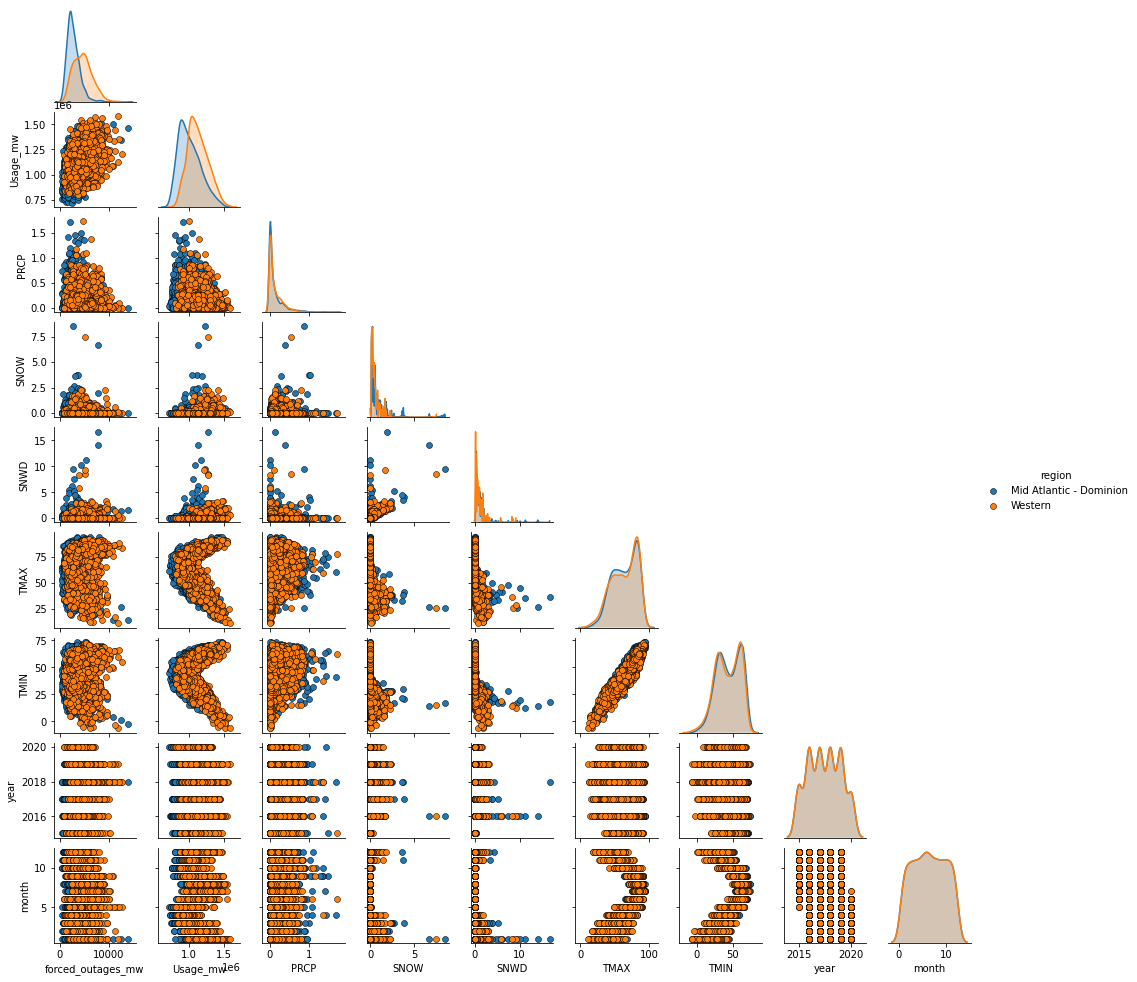

In [ ]:
outage_usage_weather_pp = sns.pairplot(df,height=1.5,
                  hue="region",
                  plot_kws=dict(edgecolor="k", linewidth=0.5),corner=True)

The Pearson Correlation Matrix below hints at a somewhat strong relationship between forced_outages_mw and Usage_mw.  This correlation is a good indicator that analysis should be around the intersection of other relationship in regard to forced_outages_mw and Usage_mw

Text(0.5, 1.0, 'Outage Usage Weather - Pearson Matrix')

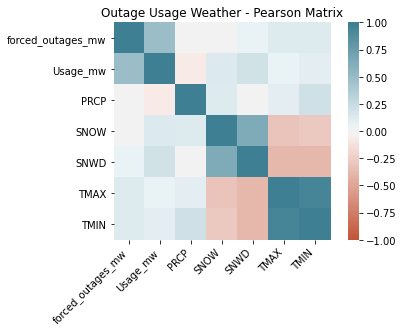

In [ ]:
corr = df_all.corr('pearson')

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.subplots_adjust(hspace = .5)
ax.set_title(f'Outage Usage Weather - Pearson Matrix')

### The Spearman correlation matrix highlights a previous weak linear relationship to a moderately strong negative non linear relationship between SNOW, SNWD in respect to TMAX and TMIN. This makes sense beacause snow fall and snow weight values should have yield different amounts of Snow fall or snow weight. 

Text(0.5, 1.0, 'Outage Usage Weather - Spearman Matrix')

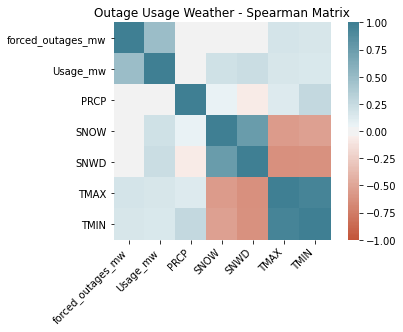

In [ ]:
corr = df_all.corr('spearman')

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.subplots_adjust(hspace = .5)
ax.set_title(f'Outage Usage Weather - Spearman Matrix')

### Decipher which region has a strong cluster with respect to the moderately strong postive relationship of Usage_mw and forced_outages_mw

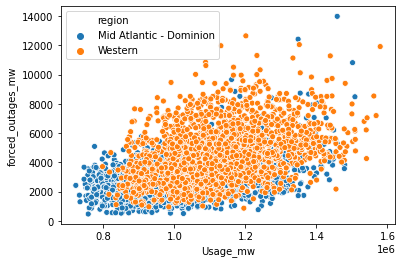

In [ ]:
_ = sns.scatterplot(x='Usage_mw',y='forced_outages_mw',data=df,hue='region')

## Mid Atlantic has a strong cluster

Mid Atlantic has a stronger cluster than Western, so Mid Atlantic will be the region of concentration

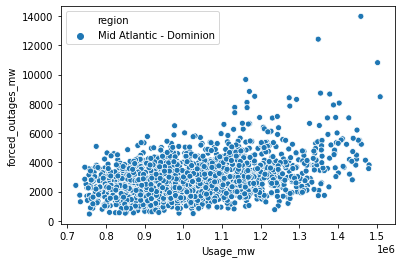

In [ ]:
df_midatl = df[df.region == 'Mid Atlantic - Dominion']
_ = sns.scatterplot(x='Usage_mw',y='forced_outages_mw',data=df_midatl,hue='region')

Western has moderately strong cluster

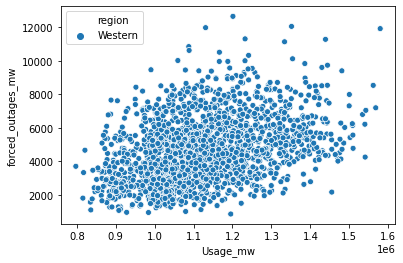

In [ ]:
df_western = df[df.region == 'Western']

_ = sns.scatterplot(x='Usage_mw',y='forced_outages_mw',data=df_western,hue='region')

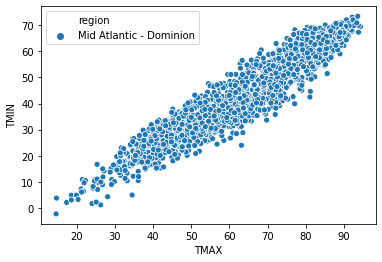

In [ ]:
df_midatl = df[df.region == 'Mid Atlantic - Dominion']
_ = sns.scatterplot(x='TMAX',y='TMIN',data=df_midatl,hue='region')

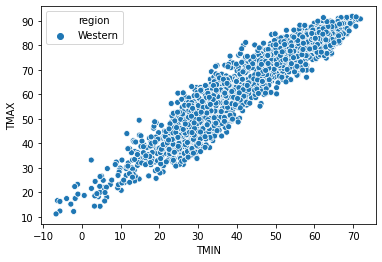

In [ ]:
df_western = df[df.region == 'Western']

_ = sns.scatterplot(x='TMIN',y='TMAX',data=df_western,hue='region')

## Interesting shape and plot with TMAX and TMIN

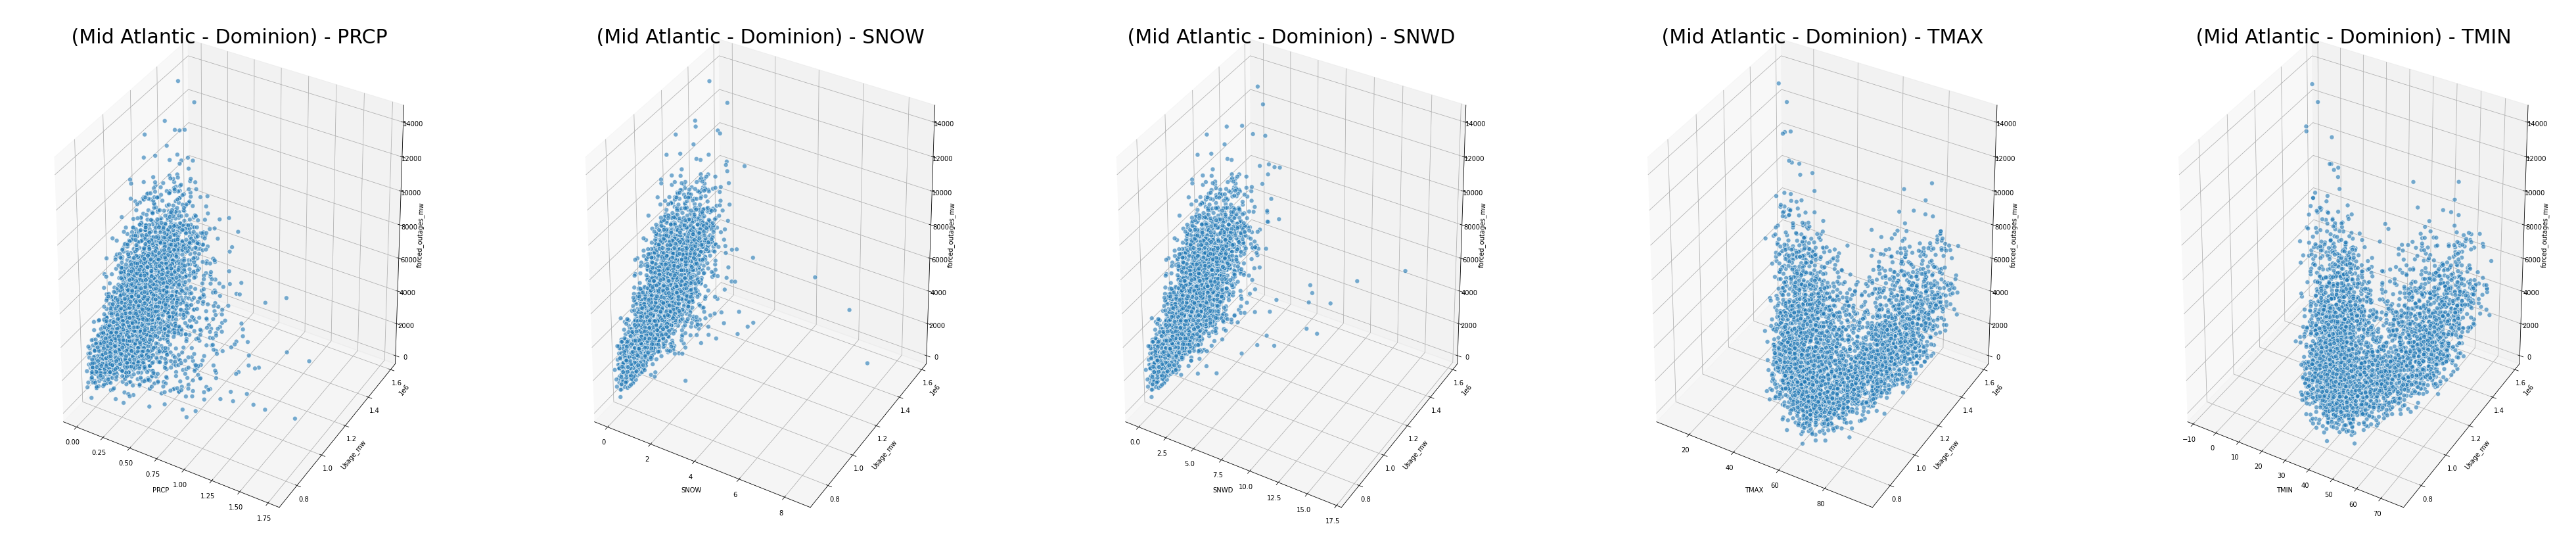

In [ ]:
df_all = df_midatl[df_midatl.select_dtypes(exclude='object').columns]



df_3d = df_all[[col for col in df_all.columns if col != 'Usage_mw']]
df_3d = df_3d[[col for col in df_3d.columns if col != 'forced_outages_mw']]
df_3d

# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth

sns.set_context(context=None, font_scale=10, rc=None)


#Make df without Usage_mw and forced_outages_mw


fig = plt.figure(figsize=(70,15))



for index, feature in enumerate(df_3d.columns,1):

    ax = fig.add_subplot(1,5,index,projection='3d')
    xs = df[f'{feature}']
    ys = df['Usage_mw']
    zs = df['forced_outages_mw']
    ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')
    
    
    ax.set_title(f' (Mid Atlantic - Dominion) - {feature}',size=30)
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Usage_mw')
    ax.set_zlabel('forced_outages_mw')

In [ ]:
#Choose what column will color the scatter plot
color ='season'

### From the plot we can see that during either TMAX yields higher usage and higher forced_outages 

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_midatl, x='TMAX', y='Usage_mw', z='forced_outages_mw',
                color= color,width=1500, height=1000,opacity=0.3, title='(Mid Atlantic - Dominion) - TMAX - Usage_MW - Forced_Outages_Mw')
fig.show()



### Same relationship with Forced outages and Usage than TMAX

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df, x='TMIN', y='Usage_mw', z='forced_outages_mw', title='TMIN - Usage_MW - Forced_Outages_Mw',
                color= color,width=1000, height=1000,opacity=0.3)
fig.show()